In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

import h5py
from utils import write_unsafe_attrs,read_CSV,convert_to_hdf_name,create_dataStructure,convert_excel_to_hdf,close_dataset,convert_to_hdf,read_Excel,CombineColumns,ReplaceValuesColumns,addColValues,dropCols
from tables import *
import requests
import json
from datetime import datetime
import os
from slugify import slugify, Slugify
from tabulate import tabulate



%matplotlib inline

def init_dataset():
        
    global dfLabels, dfDB, DatosCSV,store1
    [dfDB,dfLabels] = read_Excel()
    #[DatosCSV] = read_CSV("Datos.csv")
    store1 =  create_dataStructure('data.h5')
    


In [3]:
#####   alternativas



init_dataset()

all_data = []
stringcolumns = []
dictionary = {}
index=0

custom_slugify = Slugify(to_lower=True)
custom_slugify.separator = '_'

file=pd.ExcelFile('ScopusData.xlsx')
print(file.sheet_names)

#DB full sheet with articles
DB = file.parse('articulos')
DBLabels = file.parse('palabras y categoria')

#clean dataframe
for item in DB.columns:

    string =item.replace('\n','')
    string = custom_slugify(string.replace('\r', '').strip())
    stringcolumns.append(string)

DB.columns = stringcolumns
stringcolumns = []

for item in DBLabels.columns:

    string =item.replace('\n','')
    string = custom_slugify(string.replace('\r', '').strip())
    stringcolumns.append(string)
    
DBLabels.columns = stringcolumns
stringcolumns = []

DB = DB.fillna(0)


['articulos', 'palabras y categoria']


In [4]:
DB.describe(include='all')

columna1 author_keywords        authors   author_s_id  \
count   93.000000              93             93            93   
unique        NaN              85             92            92   
top           NaN               -  Makrominas M.  56502169000;   
freq          NaN               9              2             2   
mean    47.731183             NaN            NaN           NaN   
std     27.334538             NaN            NaN           NaN   
min      1.000000             NaN            NaN           NaN   
25%     24.000000             NaN            NaN           NaN   
50%     48.000000             NaN            NaN           NaN   
75%     71.000000             NaN            NaN           NaN   
max     94.000000             NaN            NaN           NaN   

                                            title         year  \
count                                          93    93.000000   
unique                                         93          NaN   
top     Are analysts' cash flow forecasts useful?          NaN   
freq                                            1          NaN   
mean                                          NaN  2016.010753   
std                                           NaN     1.289545   
min                                           NaN  2014.000000   
25%                                           NaN  2015.000000   
50%                                           NaN  2016.000000   
75%                                           NaN  2017.000000   
max                                           NaN  2018.000000   

                                      source_title  abbreviated_source_title  \
count                                           93                        93   
unique                                          66                        66   
top     Journal of Business Finance and Accounting  J. Bus. Financ. Account.   
freq                                             6                         6   
mean                                           NaN                       NaN   
std                                            NaN                       NaN   
min                                            NaN                       NaN   
25%                                            NaN                       NaN   
50%                                            NaN                       NaN   
75%                                            NaN                       NaN   
max                                            NaN                       NaN   

              art_no   page_start  ...  water_transportation  \
count   9.300000e+01    93.000000  ...                  93.0   
unique           NaN          NaN  ...                   NaN   
top              NaN          NaN  ...                   NaN   
freq             NaN          NaN  ...                   NaN   
mean    3.074326e+04   407.978495  ...                   0.0   
std     2.110172e+05   519.842660  ...                   0.0   
min     0.000000e+00     0.000000  ...                   0.0   
25%     0.000000e+00    43.000000  ...                   0.0   
50%     0.000000e+00   224.000000  ...                   0.0   
75%     0.000000e+00   568.000000  ...                   0.0   
max     1.650023e+06  2621.000000  ...                   0.0   

        weighted_average_cost_of_capital  willingness_to_pay  \
count                               93.0                93.0   
unique                               NaN                 NaN   
top                                  NaN                 NaN   
freq                                 NaN                 NaN   
mean                                 0.0                 0.0   
std                                  0.0                 0.0   
min                                  0.0                 0.0   
25%                                  0.0                 0.0   
50%                                  0.0                 0.0   
75%                                  0.0             

In [4]:

KeyWords = DB['author_keywords'] #selecciona las palabras clave
Labels = DBLabels['palabras_definitivas'] #crea las categorias definitivas
finalRow = [] #es un array con las palabras claves limpias y arregladas

KeyWords = [x for x in KeyWords if x != 0] #limpia el listado de keywords y elimina campos en 0


#separar cada uno de los keywords correspondiente a un articulo, separado por ;

for idx, row in enumerate(KeyWords):
    
    if row != 0:
        
        rowKeys= row.lower().split(";",-1)

        for string in rowKeys:
            string= string.replace('\r', '').strip()
            string=custom_slugify(string)
            finalRow.append(string)

        
#creamos nuevas columnas con el nombre de cada una de las KEYWORDS
#así de cada autores se va a relacionar cuales mencionar ciertos keywords
        for stringItem in finalRow:
        #si el keyword hace parte de las columnas, se agrega un 1 en esa posición
            if stringItem in DB.columns:
                DB[stringItem] = DB[stringItem].fillna(0)
                DB[stringItem].astype(int)
                DB.iloc[idx, DB.columns.get_loc(stringItem)] = 1


        finalRow=[]
        
 
DB['author_keywords'].astype(str)


0     Corporate social responsibility; Cost of Capit...
1     Cost of equity capital; Expected returns; Idio...
2     Implied cost of equity capital; board risk com...
3     Environmental sustainability; Financial perfor...
4     CAPM; implied cost of capital; policy; risk; s...
                            ...                        
88    block trades; event studies; multivariate adap...
89                                                    -
90         Cost of equity; Going concern opinion; PCAOB
91    Costly reversibility; Countercyclical price of...
92                                                    -
Name: author_keywords, Length: 93, dtype: object

Index(['Weber J.L.', 'corporate_social_responsibility', 'cost_of_capital',
       'voluntary_disclosure', 'Schreder M.', 'cost_of_equity_capital',
       'implied_cost_of_capital', 'information_risk',
       'Al-Hadi A., Hussain S.M., Al-Yahyaee K.H., Al-Jabri H.S.',
       'implied_cost_of_equity_capital', 'Gupta K.', 'Makrominas M.', 'Kim S.',
       'cost_of_equity', 'Aghazadeh S., Sun L., Wang Q., Yang R.',
       'Kim J.-B., Li B., Liu Z.', 'liquidity',
       'Alsadoun N., Naiker V., Navissi F., Sharma D.S.',
       'Taylor G., Richardson G., Al-Hadi A., Obaydin I.',
       'Aggarwal R., Mishra D., Wilson C.',
       'Gupta K., Krishnamurti C., Tourani-Rad A.', 'corporate_governance',
       'Larocque S., Lawrence A., Veenstra K.', 'Choi H., Kim H.T., Pae S.',
       'information_asymmetry', 'Jagannathan R., Liberti J., Liu B., Meier I.',
       'capital_structure', 'cost_of_debt', 'Ma M.S.', 'earnings_quality',
       'Michaels A., Grüning M.', 'Larson C.R., Resutek R.J.',
     

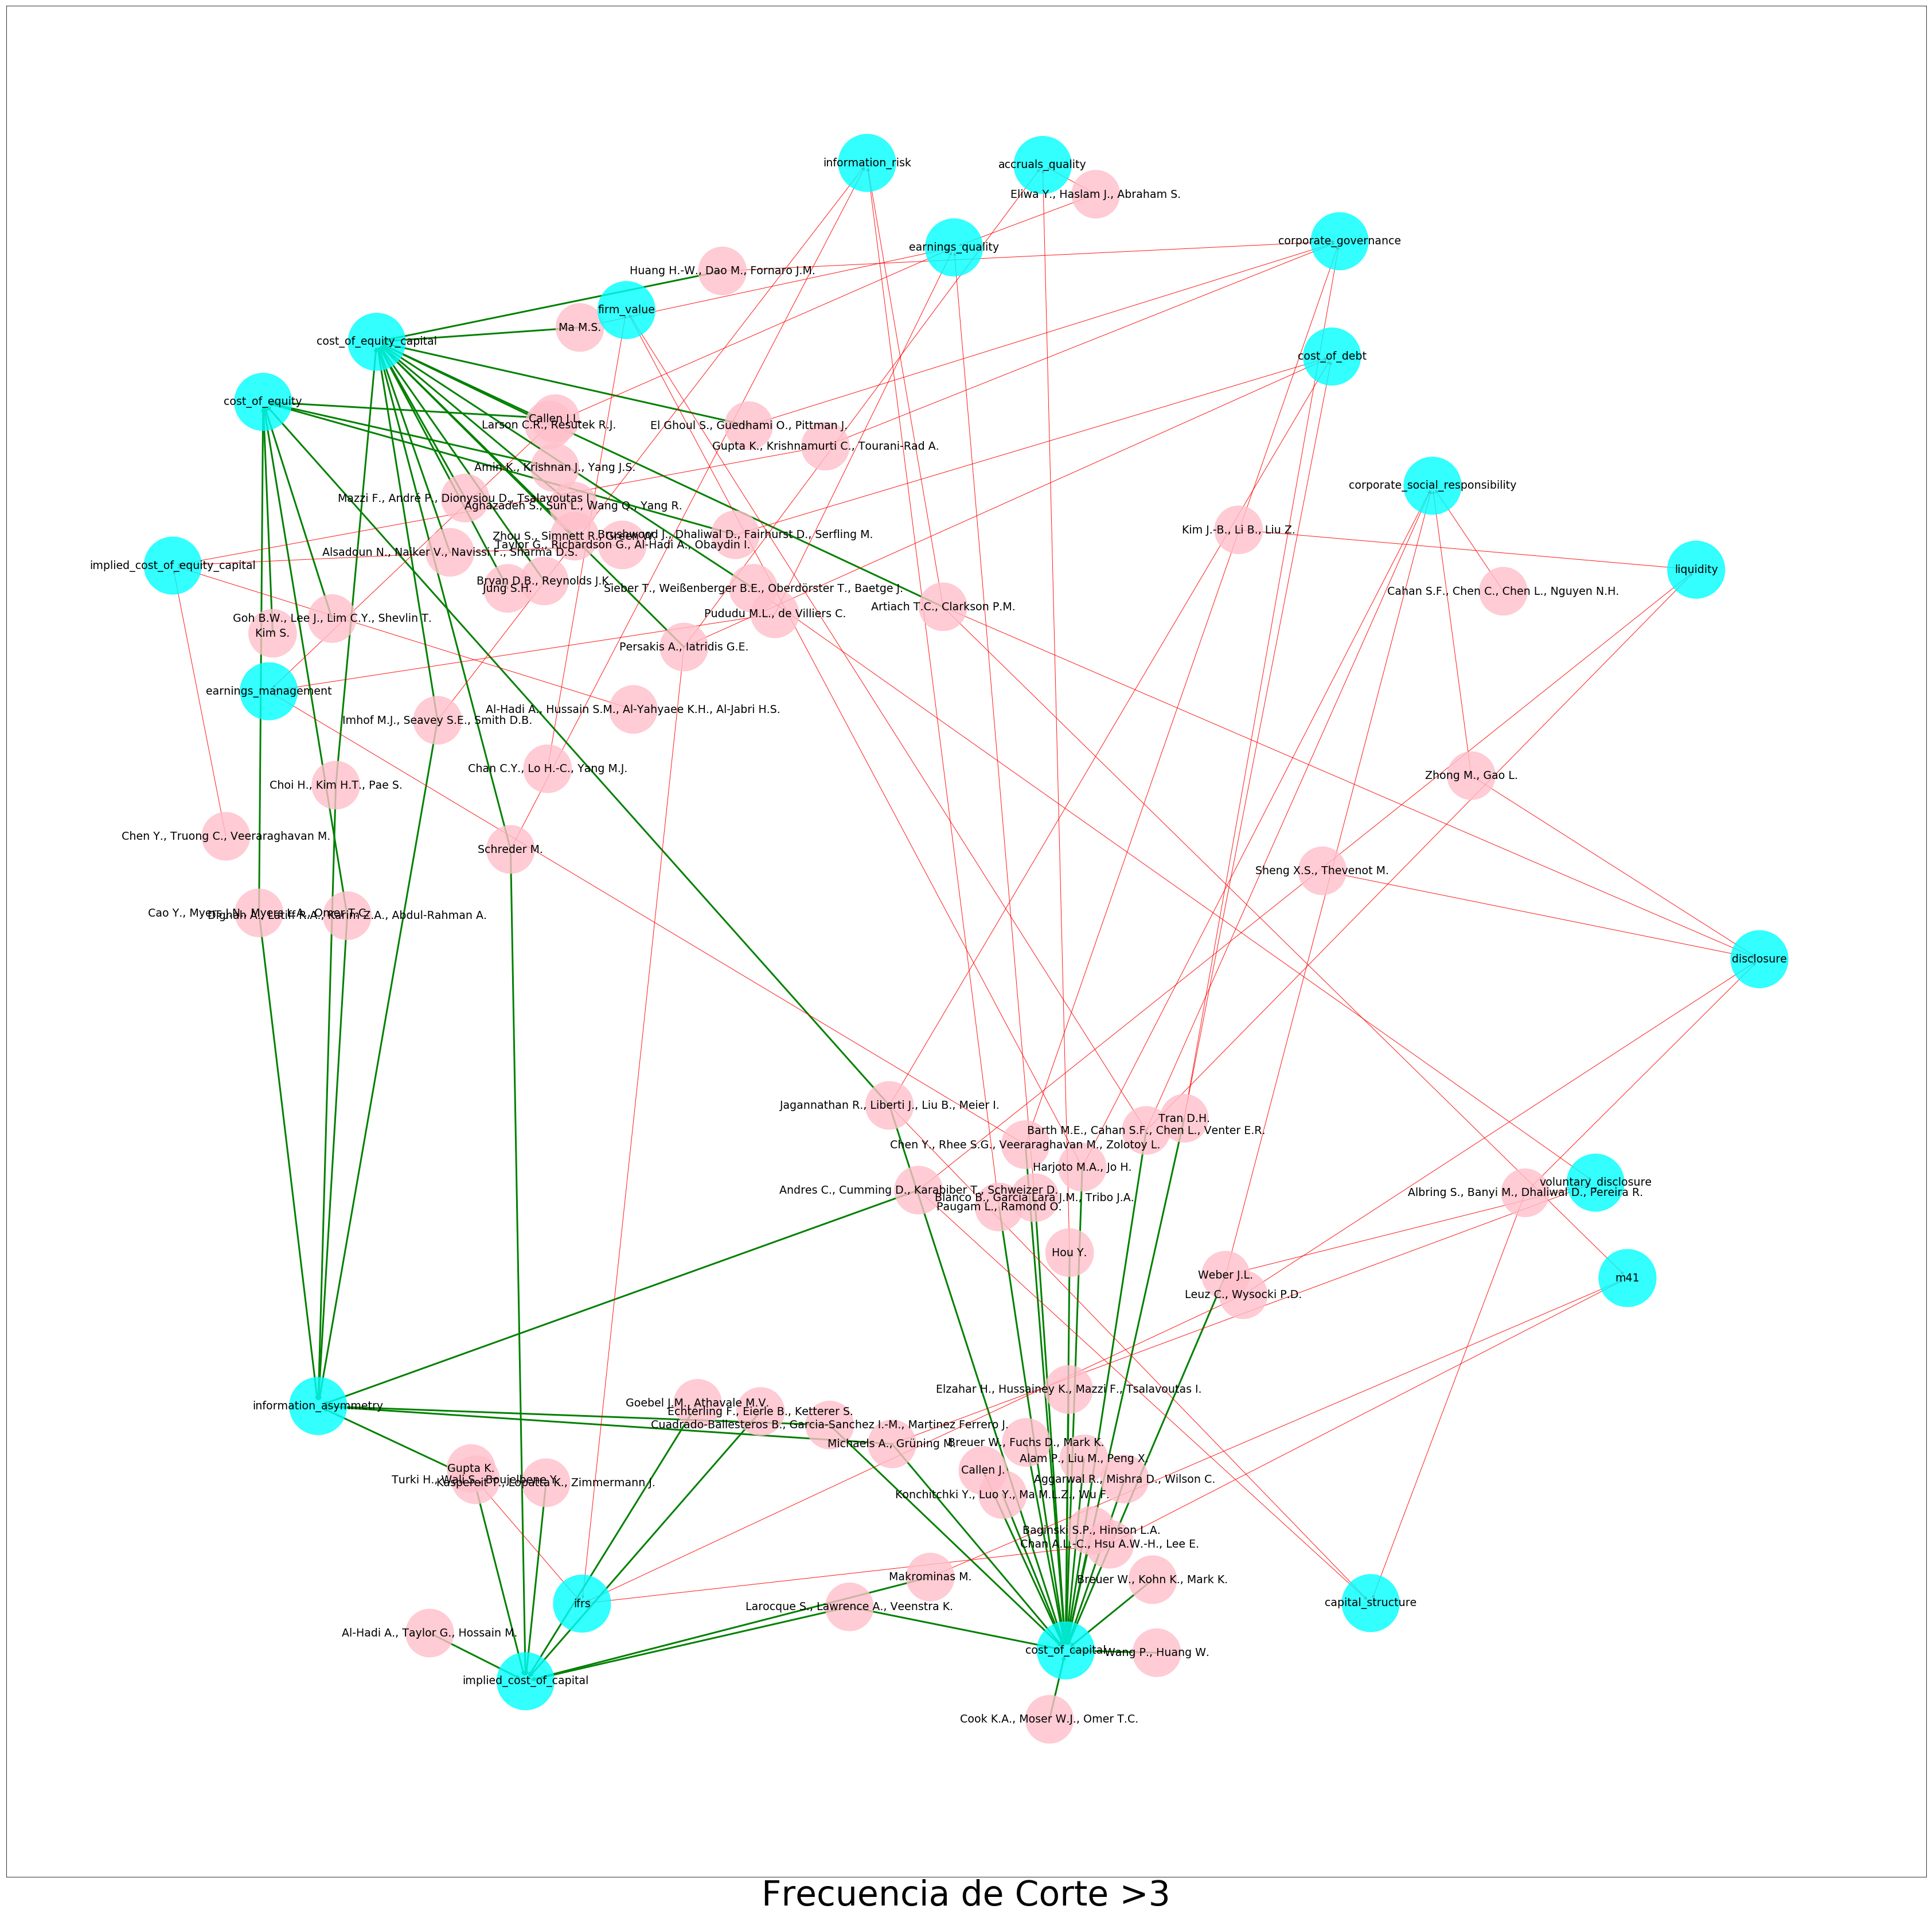

In [5]:
edges=[]
deletedrows = []
frecuenciaCorte = 3

#Estructura para crear conexiones entre términos y autores.

#eliminamos las columnas que no tienen carga util
dictDrop = {'columna1': '',
            'author_keywords':'',
            'author_s_id':'',
            'title':'',
            'year':'',
           'source_title':'',
           'abbreviated_source_title':'',
           'art_no':'',
           'page_start':'',
           'page_end':'',
           'page_count':'',
           'cited_by':'',
           'doi':'',
            'link':'',
            'affiliations':'',
            'authors_with_affiliations':'',
            'abstract':'',
            'publisher':''}

DBGraph = dropCols(dictDrop,DB.copy()) 

#evaluo las frecuencias y si el numero de citas a ese keyword son 
#menores de 5, se elimina.
KeysFrequency = DBGraph.sum(axis = 0, skipna = True).drop('authors')

for value in KeysFrequency.items():
    if value[1] < frecuenciaCorte:
        DBGraph = dropCols({value[0]:''},DBGraph) 
 

for idx,item in enumerate(DBGraph.columns):
    if idx>0 :
        rows = DBGraph[item] == 1


cols= DBGraph.columns.drop('authors') #los nombres de las columnas restantes, menos la de autores


#repasar cada fila, buscamos que elemento autor de esa fila, esta conectado con palabras clave marcadas como 1


for idx, row in DBGraph.iterrows():
    rowOriginal = row.copy() #crear una copia sin modificar de la fila
    row.pop('authors') #descartar el item authors del diccionario
    sumaAllKeyWords = row.values.sum() #calcular la suma de de la fila, para saber cuales de esos autore
                        #no mencionan ninguna de esas palabras clave
    
    if sumaAllKeyWords==0:
        DBGraph=DBGraph.drop(idx,axis=0) #si la suma es cero, se elimina la fila del dataframe
        deletedrows.append(idx) #se captura el indice de la fila borrada
    else:
        for idx,value in enumerate(row): #si la suma es mayor que 0, se itera sobre cada elemento de la fila 
                                        #aquellos con valor 1 son los que se meten al array EDGES
            if value == 1:
                parciales= DBGraph.sum(axis = 0, skipna = True).drop('authors')
                sumaTotal = parciales.sum()
                edges.append((rowOriginal[0],row.keys()[idx],{'weight':(parciales[idx])/sumaTotal}))
        
        
g = nx.DiGraph()  
g.add_edges_from(edges)  

pos=nx.fruchterman_reingold_layout(g)
#__all__ = ['bipartite_layout',
#           'circular_layout',
#           'kamada_kawai_layout',
#           'random_layout',
#           'rescale_layout',
#           'shell_layout',
#           'spring_layout',
#           'spectral_layout',
#           'planar_layout',
#           'fruchterman_reingold_layout',
#           'spiral_layout']

plt.figure(figsize = (60, 60))

elarge = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] > np.mean( DBGraph.sum(axis = 0, skipna = True).drop('authors'))/sumaTotal]
esmall = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] <= np.mean( DBGraph.sum(axis = 0, skipna = True).drop('authors'))/sumaTotal]

color_map = []
nodeSize = []

for node in g: 
   
    if node in DBGraph['authors'].values:
        color_map.append('pink')
        nodeSize.append(7000)
    else: 
        color_map.append('cyan')
        nodeSize.append(10000)

nx.draw_networkx_nodes(g, pos,
                       node_color=color_map,
                       node_size=nodeSize,
                       alpha=0.8)

nx.draw_networkx_edges(g, pos, edgelist=elarge,edge_color='g',
                       width=3,style='dashed')
nx.draw_networkx_edges(g, pos, edgelist=esmall,
                       width=1, alpha=0.9, edge_color='r')
nx.draw_networkx_labels(g, pos, font_size=19)

#plt.show()  


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.xlabel('Frecuencia de Corte >'+ str(frecuenciaCorte), fontsize=60)

AdjacencyMatrix = nx.to_pandas_adjacency(g)
print(AdjacencyMatrix.columns)
plt.savefig("Graph5.png", format="PNG")

In [6]:
#DB.to_hdf('data.h5', format= 'table', key='df', mode='w', data_columns=True)
convert_to_hdf_name(DB,'dataArticles')
convert_to_hdf_name(DBLabels,'dataLabels')

DB.to_csv (r'dataArticles.csv', header=True)
DBLabels.to_csv (r'dataLabels.csv', header=True)
AdjacencyMatrix.to_csv (r'adjacencyMatrix.csv', header=True)


C:\ProgramData\Anaconda3\envs\BigDataAnalytics\lib\site-packages\tables\leaf.py:410: PerformanceWarning: The Leaf ``/dataArticles/_i_table/abstract/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [196]:
close_dataset()

In [197]:
os.remove('data.h5')